In [15]:
import abtem
from ase.build import bulk

In [16]:
abtem.config.set({"fft": "fftw"})

# Parallelization, Dask and GPUs

The time cost of running multislice simulations can range from milliseconds to weeks depending on sample size, number of probe positions, inclusion of phonons and many other factors. *abTEM* utilizes the *Dask* library to make the best use of your available hardware to speed up your calculation, whether you are running it on a laptop or a high performance computing cluster. 

We try to make the default options as optimal as possible, hence if you are running your code on a local machine the following instruction are not required. Nonetheless, it might be iteresting to understand how your code is parallelized, you might also gain some insights by trying different schedulers and using some of the diagnostic tools we introduce. If you are running *abTEM* on a distributed computing systems you should read on. If you are an experienced Dask user, most of what you already know can be applied to *abTEM*.

## Basics of *Dask* in *abTEM*

*abTEM* is built on [Dask Array](https://docs.dask.org/en/stable/array.html){cite}`dask`, hence most method calls in *abTEM* produces or modifies a *Dask* array behind the scenes. A *Dask* array is "lazy", this means that when we create it, we only create the tasks necessary for computing it, but those tasks are yet to run.

Below we create the tasks for running the multislice algorithm many times with different frozen phonon configurations over a grid of initial scan positions. 

In [21]:
atoms = bulk("Au", cubic=True) * (4, 4, 1)

fp = abtem.FrozenPhonons(atoms, num_configs=8, sigmas=0.1, ensemble_mean=False)

potential = abtem.Potential(fp, gpts=512, slice_thickness=2)

probe = abtem.Probe(energy=100e3, semiangle_cutoff=20)

scan = abtem.GridScan.from_fractional_coordinates(
    potential, start=(0, 0), end=(1 / 4, 1 / 4)
)

probes = probe.scan(potential, detectors=abtem.WavesDetector(), scan=scan)

probes

-------------------------------------------------

type               label           coordinates
-----------------  --------------  -------------------
FrozenPhononsAxis  Frozen phonons  -
ScanAxis           x [Å]           0.00 0.41 ... 3.67
ScanAxis           y [Å]           0.00 0.41 ... 3.67
RealSpaceAxis      x [Å]           0.00 0.03 ... 16.29
RealSpaceAxis      y [Å]           0.00 0.03 ... 16.29

        bytes       shape                  count      type
------  ----------  ---------------------  ---------  -------------
array   1.56 GiB    (8, 10, 10, 512, 512)  100 tasks  complex64
chunks  112.00 MiB  (1, 8, 7, 512, 512)    32 chunks  numpy.ndarray

The result is a 1d grid of phonon configurations of a 2d grid of probe positions of 2d wave functions, which can be represented as a 5d *Dask* array. 

In [23]:
probes.array

dask.array<_extract_measurement, shape=(8, 10, 10, 512, 512), dtype=complex64, chunksize=(1, 8, 7, 512, 512), chunktype=numpy.ndarray>

The result takes up about 1.5 GB, this is not large enough to choke modern computers, hence we could compute it. However, if the simulation was larger this might not be true, hence we shall apply a reduction before computing. We can reduce the base wave function dimensions by applying 

In [20]:
measurement = abtem.AnnularDetector(inner=50, outer=150).detect(build_probe).mean(0)
measurement

---------------------------------------------------------

type           label    coordinates
-------------  -------  ------------------
RealSpaceAxis  x [Å]    0.00 0.41 ... 3.67
RealSpaceAxis  y [Å]    0.00 0.41 ... 3.67

        bytes    shape     count      type
------  -------  --------  ---------  -------------
array   400 B    (10, 10)  224 tasks  float32
chunks  224 B    (8, 7)    4 chunks   numpy.ndarray

In [8]:

measurement.compute()

[########################################] | 100% Completed | 11.7s


---------------------------------------------------------

type               label           coordinates
-----------------  --------------  ------------------
FrozenPhononsAxis  Frozen phonons  -
RealSpaceAxis      x [Å]           0.00 0.41 ... 3.67
RealSpaceAxis      y [Å]           0.00 0.41 ... 3.67

        bytes     shape        count     type
------  --------  -----------  --------  -------------
array   3.12 kiB  (8, 10, 10)  -         float32
chunks  -         -            - chunks  numpy.ndarray

When accessing the `array` property we get the *Dask* array

(<Figure size 432x288 with 2 Axes>, <Axes:xlabel='x [Å]', ylabel='y [Å]'>)

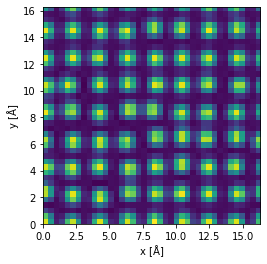

In [6]:
measurement.show()

The multislice algorithms requires running several interdependent tasks, we call this a [task graph](https://docs.dask.org/en/stable/graphs.html). All *abTEM* simulations runs by building a *Dask* task graph for the simulation, then executing that task graph using one of the *Dask* schedulers. 

### Scheduler overview

Modern computers have multiple CPU cores which are capable of performing independent tasks in parallel. When execute `compute` one of the *Dask* schedulers will assign your available computing resources to unfinished tasks, until all the required tasks for your simulation are finished, then your result is returned. 

In [10]:
build_probe.compute();

[########################################] | 100% Completed |  0.7s


For most cases, the default settings are good choices. However, sometimes you may want to use different *Dask* scheduler. Every keyword argument provided to the `compute` method in *abTEM* are forwarded to *Dask*. Hence, everything described in [*Dask*s scheduler overview](https://docs.dask.org/en/stable/scheduler-overview.html) also applies to *abTEM*. For example, we can use the scheduler keyword.

In [13]:
probe.multislice(fp).compute(scheduler="processes");

[########################################] | 100% Completed |  8.3s


Using `abtem.config.set` this can be used either as a context manager, or to set the scheduler globally.

In [16]:
# As a context manager
with abtem.config.set(scheduler="processes"):
    probe.multislice(fp).compute()

# Set globally
abtem.config.set(scheduler="processes")
probe.multislice(fp).compute();

[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.5s


-------------------------------------------------

type               label           coordinates
-----------------  --------------  -------------------
FrozenPhononsAxis  Frozen phonons  -
RealSpaceAxis      x [Å]           0.00 0.08 ... 40.72
RealSpaceAxis      y [Å]           0.00 0.08 ... 40.72

        bytes     shape          count     type
------  --------  -------------  --------  -------------
array   4.00 MiB  (2, 512, 512)  -         complex64
chunks  -         -              - chunks  numpy.ndarray

Additionally, each scheduler may take a few extra keywords specific to that scheduler. For example, the multiprocessing and threaded schedulers each take a num_workers keyword, which sets the number of processes or threads to use (defaults to number of cores). This can be set by passing the keyword when calling compute:

### Dask distributed 

everything below may also be used , the Dask distributed scheduler provides a great diagnostic tool
YOu can 

Since *abTEM* just creates a *Dask* task graph, 





In [ ]:
This happens automatically, however, to get 

if you are running simulations, you may want 

On a local system (a laptop or desktop), your calculation is parallelized automatically. Nonetheless, it is possible that your calculation runs faster using a distributed scheduler, this will also provide 


Nonetheless, you may benefit from knowing about , on larger systems (e.g. HPC clusters), it is necessary.

*abTEM* uses the 

as *abTEM


https://docs.dask.org/en/stable/scheduling.html

Parallel computation in abTEM whether it is running on a laptop or a High Performance Computing cluster is parallelized through . 

Some knowledge of Dask may be required to run abTEM effectively on large multi-CPU/GPU systems, however, if you are just running abTEM on your own computer, this tutorial gets you started. If you want a quick introduction to Dask, we recommend thishttps://www.youtube.com/watch?v=nnndxbr_Xq4&t=66s) short youtube video.

## GPUs

Almost every part of *abTEM* is implemented on GPU using the `CuPy` library. If you have a single GPU and a working installation of CuPy, you can use your GPU by changing the configs as below:

In [12]:
abtem.config.set({"device": "gpu"})

### Multiple GPUs


## Memory